In [1]:
from docx import Document
from itertools import combinations
import nltk
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.stem.snowball import RussianStemmer
import networkx as nx
from collections import OrderedDict

nltk.download('punkt')

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Екатерина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def similarity(s1, s2):
    if not len(s1) or not len(s2):
        return 0.0
    return len(s1.intersection(s2))/(1.0 * (len(s1) + len(s2)))

# Выдает список предложений отсортированных по значимости
def textrank(text):
    sentences = sent_tokenize(text)
    tokenizer = RegexpTokenizer(r'\w+')
    lmtzr = RussianStemmer()
    words = [set(lmtzr.stem(word) for word in tokenizer.tokenize(sentence.lower()))
             for sentence in sentences]
    pairs = combinations(range(len(sentences)), 2)
    scores = [(i, j, similarity(words[i], words[j])) for i, j in pairs]
    scores = filter(lambda x: x[2], scores)
    g = nx.Graph()
    g.add_weighted_edges_from(scores)
    pr = nx.pagerank(g)
    return sorted(((i, pr[i], s) for i, s in enumerate(sentences) if i in pr), key=lambda x: pr[x[0]], reverse=True)

# Сокращает текст до нескольких наиболее важных предложений
def sumextract(text, n=5):
    tr = textrank(text)
    top_n = sorted(tr[:n])
    return ' '.join(x[2] for x in top_n)

def is_heading(par):
    return par.style.name.startswith('Heading')

#def create_heatmap(similarity, cmap = "YlGnBu"):
  #df = pd.DataFrame(similarity)
  #df.columns = labels
  #df.index = labels
  
def iterate_docx(doc):
    paragraphs = [doc.paragraphs[0]]
    for paragraph in doc.paragraphs[1:]:
        #print(paragraph)
        if is_heading(paragraph):
            yield paragraphs
            paragraphs = [paragraph]
            continue
        paragraphs.append(paragraph)
    yield paragraphs

doc1 = Document('data/file.docx')
doc2 = Document('data/sample.docx')

l1 = []
for par in iterate_docx(doc1):
    l1.append(''.join(o.text for o in par[1:]))
    #req.update({par[0].text: ''.join(o.text for o in par[1:])})
for par in iterate_docx(doc2):
    l1.append(''.join(o.text for o in par[1:]))
    #specs.update({par[0].text: ''.join(o.text for o in par[1:])})
#filtered_dict = dict(filter(lambda x: (not x[0].lower().startswith('Приложение')), res.items()))
print(len(l1))

205


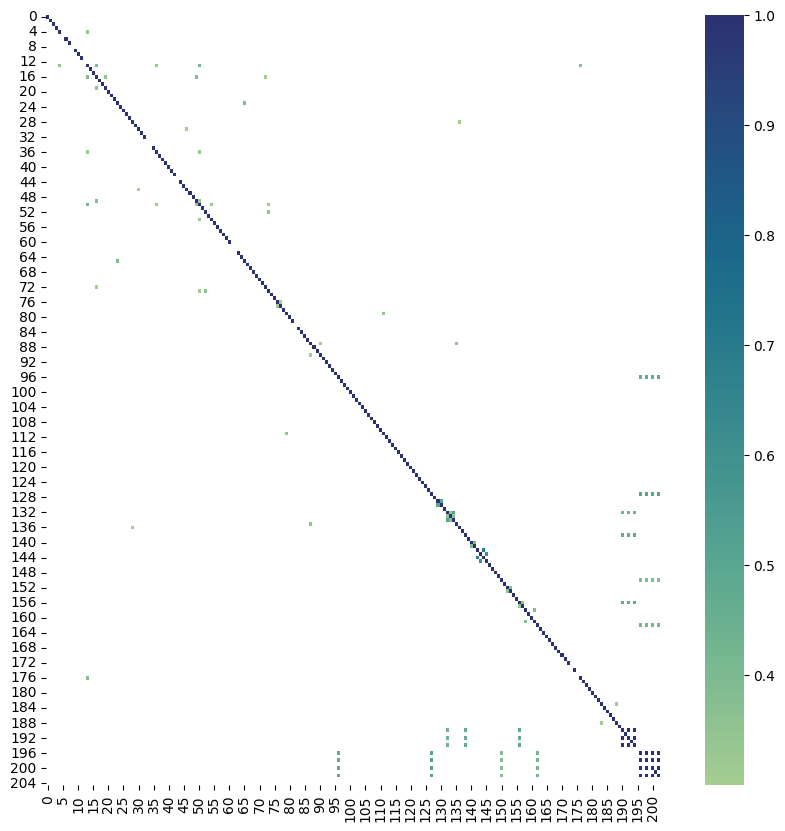

In [6]:
# Первый векторизатор 
labels = [l[:20] for l in l1]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(l1)
arr = X.toarray()

# Считаем косинусное сходство
cos_sim = cosine_similarity(arr)

# Заменяем значения меньше или равные 0.3 на NaN
cos_sim_filtered = np.where(cos_sim > 0.3, cos_sim, np.nan)
# Строим heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cos_sim_filtered, cmap='crest')
plt.show()

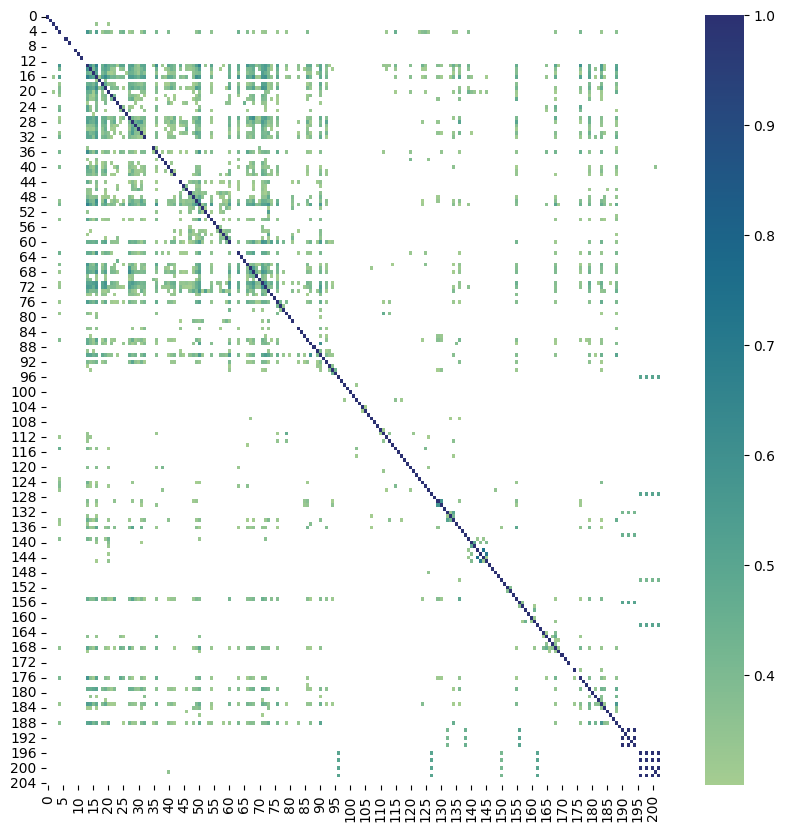

In [7]:
# Второй векторизатор для сравнения
vectorizer_2 = CountVectorizer()
X_2 = vectorizer_2.fit_transform(l1)
arr_2 = X_2.toarray()
# Считаем косинусное сходство
cos_sim_2 = cosine_similarity(arr_2)

# Заменяем значения меньше или равные 0.3 на NaN
cos_sim_filtered_2 = np.where(cos_sim_2 > 0.3, cos_sim_2, np.nan)
# Строим heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cos_sim_filtered_2, cmap='crest')
plt.show()